In [ ]:
import zipfile, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

In [2]:
zip_path = "/content/clean_dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/gesture based")

os.listdir("/content/clean_dataset")


['up', 'down', 'fist', 'open']

train/valid datasets

In [5]:
DATA_DIR = pathlib.Path("/content/clean_dataset")
IMG_SIZE = (64, 64)
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
)

class_names = train_ds.class_names
print("Class order:", class_names)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Class order: ['down', 'fist', 'open', 'up']


Model

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

def make_model(input_shape=(64, 64, 3), num_classes=4):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255.0)(x)

    # Block 1
    x = layers.Conv2D(16, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 32x32

    # Block 2
    x = layers.SeparableConv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 16x16

    # Block 3
    x = layers.SeparableConv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 8x8

    # Block 4
    x = layers.SeparableConv2D(96, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="tiny_gesture_cnn")
    return model

model = make_model()
model.summary()


Model: "tiny_gesture_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        432       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 16)        64        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64, 64, 16)   

compile and train

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=3,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=8,
        restore_best_weights=True,
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks,
)


Epoch 1/40
100/100 [==============================] - 13s 122ms/step - loss: 0.9577 - accuracy: 0.5877 - val_loss: 1.4476 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 12s 119ms/step - loss: 0.6501 - accuracy: 0.7725 - val_loss: 2.5221 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 11s 107ms/step - loss: 0.4516 - accuracy: 0.8608 - val_loss: 2.9886 - val_accuracy: 0.2569 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 12s 116ms/step - loss: 0.3134 - accuracy: 0.9114 - val_loss: 3.2142 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 12s 121ms/step - loss: 0.2356 - accuracy: 0.9312 - val_loss: 2.5265 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 12s 123ms/step - loss: 0.1797 - accuracy: 0.9525 - val_loss: 2.1944 - val_accuracy: 0.4025 - lr: 0.0010
Epoch 7/40
100/100 [==============================] 

Quick evaluation and confusion matrix

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


Classification report:
              precision    recall  f1-score   support

        down       1.00      1.00      1.00       373
        fist       0.99      0.98      0.99       414
        open       0.99      0.99      0.99       422
          up       0.99      0.99      0.99       391

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600

Confusion matrix:
 [[373   0   0   0]
 [  0 406   5   3]
 [  0   3 419   0]
 [  1   0   1 389]]


99% Accuracy. This is **beautiful**.

Train v/s Test graph

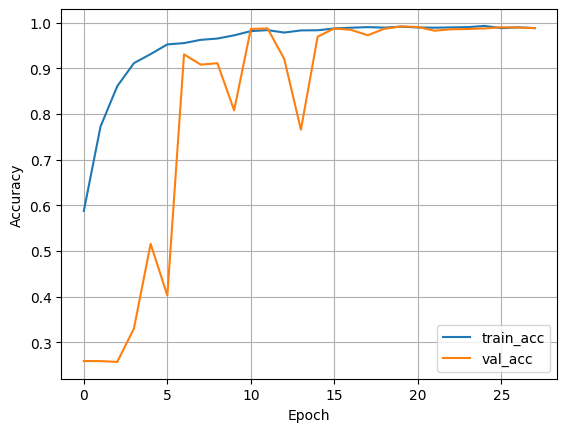

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Save the Keras model

In [9]:
model.save("/content/gesture_model_fp32.h5")


/Users/pavansaipendry/.pyenv/versions/3.8.10/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Export the int8 TFLite version (for ESP32-S3)

In [11]:
import tensorflow as tf

def representative_data_gen():
    for images, _ in train_ds.take(100):
        images = tf.cast(images, tf.float32) / 255.0
        yield [images]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()
with open("/content/gesture_model_int8.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/mn/hjst4hfn3hz0qrl8b96gq72h0000gn/T/tmpv38aux17/assets


INFO:tensorflow:Assets written to: /var/folders/mn/hjst4hfn3hz0qrl8b96gq72h0000gn/T/tmpv38aux17/assets
/Users/pavansaipendry/.pyenv/versions/3.8.10/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-11-16 14:47:10.675004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-11-16 14:47:10.675158: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-16 14:47:10.677299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/mn/hjst4hfn3hz0qrl8b96gq72h0000gn/T/tmpv38aux17
2025-11-16 14:47:10.681531: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-11-16 14:47:10.681542: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/mn/hjst4hfn3hz